<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Initialisation" data-toc-modified-id="Initialisation-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Initialisation</a></span></li><li><span><a href="#Data-inspection" data-toc-modified-id="Data-inspection-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data inspection</a></span></li><li><span><a href="#Correction-of-sample-drifts" data-toc-modified-id="Correction-of-sample-drifts-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Correction of sample drifts</a></span></li><li><span><a href="#Transformation-from-angular-to-reciprocal-space" data-toc-modified-id="Transformation-from-angular-to-reciprocal-space-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Transformation from angular to reciprocal space</a></span></li><li><span><a href="#Determination-of-a-ROI-in-reciprocal-space" data-toc-modified-id="Determination-of-a-ROI-in-reciprocal-space-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Determination of a ROI in reciprocal space</a></span></li><li><span><a href="#Calculation-and-visualisation-of-local-structural-parameters" data-toc-modified-id="Calculation-and-visualisation-of-local-structural-parameters-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Calculation and visualisation of local structural parameters</a></span></li></ul></div>

This notebook exposes the data analysis pipeline needed to obtain the local:

* peak intensity
* interplanar distance
* tilt

from a typical 3D-SXDM measurement performed on beamline ID01 @ ESRF. 

A 3D-SXDM measurement is defined as the output of a `dsxdm_3D()` BLISS command, and corresponds to a series of `dsxdm()` scans - i.e., to a series of SXDM maps taken at different incidence angles of the X-ray beam. Each map results from a raster scan of a chosen sample area relative to the focussed beam. At each beam position, a detector frame is collected. Thus, raw data from a single SXDM map is in the form $I(x, y, \mathsf{detX}, \mathsf{detY})$, where $I$ is the scattered intensity, $(x, y)$ are the positions of the sample relative to the beam, and $(\mathsf{detX}, \mathsf{detY})$ are the horizontal and vertical directions of the 2D detector active area.

A 3D-SXDM dataset is therefore 5-dimensional, its data being in the form $I(x, y, \eta, \mathsf{detX}, \mathsf{detY})$, where $\eta$ is the incidence (or rocking) angle. This notebook processes the raw data so that a linear transformation from angular to reciprocal space coordinates is performed, i.e.:

$$ I(x, y, \eta, \mathsf{detX}, \mathsf{detY}) \to I(x, y, q_x, q_y, q_z) $$

This transformation requires knowledge of the diffractometer geometry and angles (not simply $\eta$), and to interpolate data on an orthogonal grid. From $I(x, y, q_x, q_y, q_z)$ one can then compute the centre of mass of the intensity as a function of sample position, obtaining $\vec{q}(x, y)$. This allows one to finally compute the local structural parameters listed above.

<div class="alert alert-block alert-info">
<b>Note:</b> Jupyter notebooks run on <code>IPython</code>, meaning that one can inspect the docstring of an <code>object</code> by using the syntax <code>object?</code>. Don't hesitate to explore the functionality of the code below beyond this notebook by inspecting docstrings!
</div>

Some useful links:
* [Jupyter notebook basics](https://nbviewer.org/github/jupyter/notebook/blob/main/docs/source/examples/Notebook/Notebook%20Basics.ipynb)
* [ID01 Confluence](https://confluence.esrf.fr/display/BLID01KB)
* [id01-science](https://gitlab.esrf.fr/id01-science) group of GitLab repositories

# Initialisation 

If this was not done already in a different notebook, run the cell below. It will install the virtual environment containing some Python code required to run the rest of the notebook.

In [1]:
%%bash

pip3 install ipykernel
source /data/id01/inhouse/data_analysis/software/pyenvs/sxdm.slurm/bin/activate
python3 -m ipykernel install --user --name sxdm.slurm

Installed kernelspec sxdm.slurm in /home/esrf/zatterin/.local/share/jupyter/kernels/sxdm.slurm


Once the cell above has been run, **refresh the page** (`Ctrl-R`) and using the top bar navigate to `Kernel > Change Kernel > sxdm.slurm`. This will restart the Jupyter kernel to one that has access to the additional Python code needed to run this notebook.

The cell below further import Python libraries needed to run the notebook.

In [2]:
%matplotlib widget

import sxdm
import id01lib
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import h5py
import hdf5plugin
import ipywidgets as ipw

from h5glance import H5Glance as h5p
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable

mpl.rcParams['image.origin'] = 'lower'
mpl.rcParams['font.family'] = 'Liberation Sans'
mpl.rcParams['figure.dpi'] = 100

# Data inspection

First the **experiment** directory is specified:

In [3]:
path_exp = '/data/id01/inhouse/edo/tutorial_data/'

This is a mock directory containing a **sample** called `ech_1_night`:

In [4]:
ls -l {path_exp}

total 1
drwxr-xr-x 3 zatterin id01 4096 Aug 25 18:09 ech_1_night1/
drwxr-xr-x 2 zatterin id01 4096 Aug 25 20:05 ech_1_night1_analysis/


In reality the experiment directory will likely contain multiple sample directories to choose fom. The variable `name_sample` is modified below to match a chosen sample, and list its contents:

In [5]:
name_sample = 'ech_1_night1'

!tree {path_exp}/{name_sample} -L 1

/data/id01/inhouse/edo/tutorial_data//ech_1_night1
└── ech_1_night1_0010

1 directory, 0 files


The subfolder above corresponds to a specific **dataset** associated with the chosen sample. Once more, during a real experiment one normally obtains multiple datasets and therefore multiple directories are generated. A dataset can be chosen by simply specifying its number:

In [6]:
name_dset = '0010'
path_dset = f'{path_exp}/{name_sample}/{name_sample}_{name_dset}/{name_sample}_{name_dset}.h5'

and its contents inspected using the `InspectROI` widget:

In [7]:
viz = sxdm.widgets.bliss.InspectROI(path_dset)
viz.show()

It is useful to specify the scan numbers of interest (these are sometimes only a subset of a dataset):

In [8]:
scan_nums = [f"{x}.1" for x in range(1, 6)]

# Correction of sample drifts 

Once one is happy with the *dataset* choice, one proceeds to check if the data has to be corrected for **sample drifts**. That is, if movements of the visible area with incidence angle relative to the field of view (FoV), which could make interesting features disappear from the FoV as the incidence angle changes have to be compensated.

To do this, the `get_shift` function is used. This relies on [`skimage.registration.phase_cross_correlation`](https://scikit-image.org/docs/stable/api/skimage.registration.html#skimage.registration.phase_cross_correlation) so that it accepts also its keyword arguments - `reference_mask` being often a useful one (see below). 

Start by choosing `mpx1x4_mpx4int` as the signal to track between different SXDM maps as it is visible at all angles:

In [9]:
shifts, sxdm_raw, sxdm_shift = sxdm.utils.get_shift(
    path_dset,
    roi="mpx1x4_mpx4int",
    scan_nums=scan_nums,
    return_maps=True,
    med_filt=(2,2),
)

  0%|          | 0/4 [00:00<?, ?it/s]

To check that the shifts have been estimated correctly, the shifted and un-shifted maps are plotted side-by-side:

interactive(children=(IntSlider(value=0, description='i', max=4), Output()), _dom_classes=('widget-interact',)…

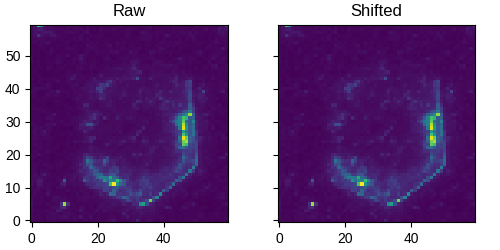

In [10]:
fig, ax = plt.subplots(1,2, figsize=(5,2.5), sharex=True, sharey=True, constrained_layout=True)

im_raw   = ax[0].imshow(sxdm_raw[0], origin='lower')
im_shift = ax[1].imshow(sxdm_shift[0], origin='lower')

ax[0].set_title('Raw')
ax[1].set_title('Shifted')

@ipw.interact(i=(0, len(sxdm_raw)-1, 1))
def compare_raw_and_shifted(i=0):
    im_raw.set_data(sxdm_raw[i])
    im_shift.set_data(sxdm_shift[i])
    
    im_raw.set_clim(sxdm_raw[i].min(), sxdm_raw[i].max())
    im_shift.set_clim(im_raw.get_clim())
    
    fig.canvas.draw()

Clearly this did not work as desired. The problem is that the spatial distribution of the ROI sum changes abruptly in the middle of the rocking curve, a common scenarion when dealing with strained epitaxial layers. 

If the sample drift can be assumed to be linear, as is the case when it stems from the sample not sitting at the diffractometer's centre of rotation, one can simply discard the scan where the intensity changes abruptly and use the rest to estimate the shift; then, the missing shift point is found by interpolation. Start by defining the index of the "outlier" as `bad_idx`:

In [11]:
bad_idx = 2

The corresponding scan is removed from the list defined above:

In [12]:
scan_nums_red = scan_nums[:]
scan_nums_red.remove(scan_nums[bad_idx])

To avoid less dramatic, but still present, abrupt intensity changes, only the top portion of the maps is selected for the shift estimation. Inspection of the data should convince one that this region is the most reliable. The selection is made by constructing a boolean mask `True` only in the top portion of the maps, and feeding it to the `reference_mask` parameter:

In [13]:
mask = np.zeros(sxdm.io.bliss.get_scan_shape(path_dset, '1.1'))
mask[35:, :] = 1

shifts, sxdm_raw, sxdm_shift = sxdm.utils.get_shift(
    path_dset,
    roi="mpx1x4_mpx4int",
    scan_nums=scan_nums_red,
    return_maps=True,
    med_filt=(2,2),
    reference_mask=mask,
)

  0%|          | 0/3 [00:00<?, ?it/s]

Now check:

interactive(children=(IntSlider(value=0, description='i', max=3), Output()), _dom_classes=('widget-interact',)…

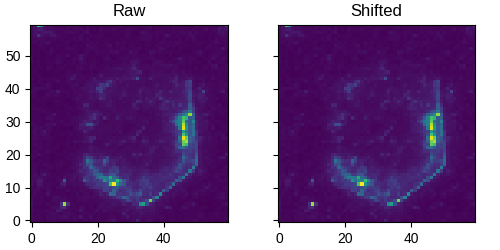

In [14]:
fig, ax = plt.subplots(1,2, figsize=(5,2.5), sharex=True, sharey=True, constrained_layout=True)

im_raw   = ax[0].imshow(sxdm_raw[0], origin='lower')
im_shift = ax[1].imshow(sxdm_shift[0], origin='lower')

ax[0].set_title('Raw')
ax[1].set_title('Shifted')

@ipw.interact(i=(0, len(sxdm_raw)-1, 1))
def compare_raw_and_shifted(i=0):
    im_raw.set_data(sxdm_raw[i])
    im_shift.set_data(sxdm_shift[i])
    
    im_raw.set_clim(sxdm_raw[i].min(), sxdm_raw[i].max())
    im_shift.set_clim(im_raw.get_clim())
    
    fig.canvas.draw()

This looks convincing. Finally, the (partial) shifts are fitted with a straight line and the missing shift is found by interpolating at the `bad_idx`:

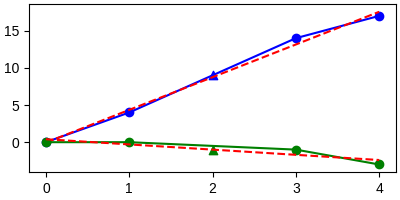

In [15]:
scan_idxs = np.arange(len(scan_nums))
scan_idxs_red = np.delete(scan_idxs, bad_idx)

ft_rows, ft_cols = [np.polyfit(scan_idxs_red, sh, 1) for sh in shifts.T] # 1D polynomial fit
sh_rows, sh_cols = [scan_idxs*f[0] + f[1] for f in (ft_rows, ft_cols)] # 

shm_row, shm_col = [np.interp(bad_idx, scan_idxs, sh) for sh in (sh_rows, sh_cols)]
shm_row, shm_col = [np.round(sh) for sh in (shm_row, shm_col)]

fig, ax = plt.subplots(1,1,figsize=(4,2), layout='constrained')

ax.plot(scan_idxs_red, shifts[:,0], marker='o', c='b')
ax.plot(scan_idxs, sh_rows, c='r', ls='--')
ax.scatter(bad_idx, shm_row, c='b', marker='^')

ax.plot(scan_idxs_red, shifts[:,1], marker='o', c='g')
ax.plot(scan_idxs, sh_cols, c='r', ls='--')
ax.scatter(bad_idx, shm_col, c='g', marker='^')

In [16]:
import scipy.ndimage as ndi

shifts = np.insert(shifts, bad_idx, np.array([shm_row, shm_col]), axis=0)

sxdm_raw = [sxdm.io.bliss.get_roidata(path_dset, s, 'mpx1x4_mpx4int') for s in scan_nums]
sxdm_shift = [ndi.shift(m, s) for m, s in zip(sxdm_raw, shifts)]

interactive(children=(IntSlider(value=0, description='i', max=4), Output()), _dom_classes=('widget-interact',)…

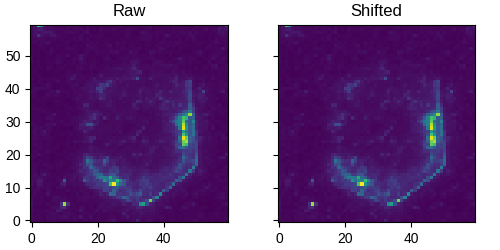

In [17]:
window = np.s_[:,:]
# window = np.s_[int(shifts[:,0].max()):int(shifts[:,0].min()), :int(shifts[:,1].min())]

fig, ax = plt.subplots(1,2, figsize=(5,2.5), sharex=True, sharey=True, constrained_layout=True)

im_raw   = ax[0].imshow(sxdm_raw[0][window], origin='lower')
im_shift = ax[1].imshow(sxdm_shift[0][window], origin='lower')

ax[0].set_title('Raw')
ax[1].set_title('Shifted')

@ipw.interact(i=(0, len(sxdm_raw)-1, 1))
def compare_raw_and_shifted(i=0):
    im_raw.set_data(sxdm_raw[i][window])
    im_shift.set_data(sxdm_shift[i][window])
    
    im_raw.set_clim(sxdm_raw[i].min(), sxdm_raw[i].max())
    im_shift.set_clim(im_raw.get_clim())
    
    fig.canvas.draw()

Uncomment the second `window` definition above to visualise only the smallest non-moving FoV given the estimated shift.

<div class="alert alert-block alert-danger">
<b>Warning:</b> this automatic shift estimation may not always work if the distribution of intensity in the map is changing too fast between one angle and the next. In such case, it is best to <u>run the cell below</u> and then <b>STOP</b> using the notebook, performing the q-space transform with <a href="https://kmap.gitlab-pages.esrf.fr/xsocs/">XSOCS</a>. This will allow one to use its <a href="https://kmap.gitlab-pages.esrf.fr/xsocs/usage/intensity_view.html#shift-scan-sample-positions">interactive shifting tool</a>. Initialise an XSOCS project in <code>path_out</code>, perform the q-space transofrm, and resume working in this notebook from the section on the <a href="https://jupyter-slurm.esrf.fr/user/zatterin/notebooks/beamtimes/user/in1141_Barbier/analysis/ech_1/m2205/ech_1_-2205_sxdm-qconv.ipynb#Determination-of-a-ROI-in-reciprocal-space">determination of a q-space ROI</a>.
</div>

Once the shift estimation is satisfactory, one proceeds to specify an **output directory** where processed data relative to this dataset will be stored. The function `make_xsocs_links` is then used to generate files that contain **links** to the raw data and an internal structure than can be read by the software [XSOCS](https://kmap.gitlab-pages.esrf.fr/xsocs/):

In [20]:
ls -lh {path_out}

total 248M
-rw-r--r-- 1 zatterin id01  61K Aug 25 20:03 ech_1_night1_0010_1.1.h5
-rw-r--r-- 1 zatterin id01  42M Aug 26 12:00 ech_1_night1_0010_1.1_shifted.h5
-rw-r--r-- 1 zatterin id01  61K Aug 25 20:03 ech_1_night1_0010_2.1.h5
-rw-r--r-- 1 zatterin id01  42M Aug 26 12:00 ech_1_night1_0010_2.1_shifted.h5
-rw-r--r-- 1 zatterin id01  61K Aug 25 20:03 ech_1_night1_0010_3.1.h5
-rw-r--r-- 1 zatterin id01  43M Aug 26 12:00 ech_1_night1_0010_3.1_shifted.h5
-rw-r--r-- 1 zatterin id01  61K Aug 25 20:03 ech_1_night1_0010_4.1.h5
-rw-r--r-- 1 zatterin id01  42M Aug 26 12:00 ech_1_night1_0010_4.1_shifted.h5
-rw-r--r-- 1 zatterin id01  61K Aug 25 20:03 ech_1_night1_0010_5.1.h5
-rw-r--r-- 1 zatterin id01  42M Aug 26 12:00 ech_1_night1_0010_5.1_shifted.h5
-rw-r--r-- 1 zatterin id01 1.1K Aug 25 20:03 ech_1_night1_0010_master.h5
-rw-r--r-- 1 zatterin id01 1.2K Aug 26 12:00 ech_1_night1_0010_master_shifted.h5
-rw-r--r-- 1 zatterin id01  39M Aug 25 20:05 qspace_shift_0.h5


In [18]:
path_out = f'{path_exp}/{name_sample}_analysis'

sxdm.utils.bliss.make_xsocs_links(path_dset, path_out, scan_nums)

> Selecting scans 1.1 --> 5.1 in ech_1_night1_0010


KeyError: 'Unable to open object (component not found)'

Having a XSOCS-compatible representation of the raw data, one can now proceed to correct the raw data for drifts using the calculated `shifts`. This is done with the function `shift_xsocs_data`.

<div class="alert alert-block alert-danger">
<b>Warning:</b> this will take a while, about 18min on a 40-core machine - 516^2 * number_of_angles shift operations are being performed!
</div>

In [18]:
%%time

# if False:
sxdm.process.xsocs.shift_xsocs_data(path_dset, path_out, shifts)

20/21                                                                                                        CPU times: user 231 ms, sys: 328 ms, total: 559 ms
Wall time: 37.4 s


Once the shifting is done, the path to the so-called XSOCS (shifted) "master file" are defined. This file contains links to the actual (shifted) data, which in contrast to the raw data, is physically stored in `path_out`.

In [21]:
path_master_shifted = f"{path_out}/{name_sample}_{name_dset}_master_shifted.h5"

# Transformation from angular to reciprocal space

Expressing data in orthonormal reciprocal space is based on the angular values read from the diffractometer's motors. Discrepancies between the "real" and experimental value of these angles may exists due to alignment imprecisions, or due to measurement of the Bragg signal in a portion of the detector that *does not* correspond to the "central pixel", i.e. the pixel hit by the maximum of the direct X-ray beam when all diffractometer angles are zero.

To estimate such angular offsets, first the sum all of the detector frames collected as part of a SXDM map at a given angle is taken; scan `30.1` is chosen, as this represents the middle of the rocking curve and should correspond to a slice in reciprocal space of the most intense portion of the probed Bragg peak: 

In [22]:
fint = sxdm.io.bliss.get_sxdm_frame_sum(path_dset, '3.1')

  0%|          | 0/40 [00:00<?, ?it/s]

The array `fint` has the shape of the detector active area, i.e.

In [25]:
fint.shape

(516, 516)

The function `get_qspace_vals` is then used to obtain the $(q_x,q_y, q_z)$ coordinate of each pixel in the frame sum `fint`, i.e. a $\vec{q}$ is associated with each pixel:

In [26]:
offsets = {'eta':0, 'delta':0, 'phi':0, 'roby':0, 'nu':0}
qx, qy, qz = id01lib.xrd.qspace.bliss.get_qspace_vals(path_dset, '3.1', offsets=offsets)

Using cen_pix: x=138.845, y=256.169
Using det_dist = 0.94004 m
Using energy = 8.99971 keV
NOT correcting the central pixel for mpxy=-14.0, mpxz=0.0


These have the same shape as `fint`,

In [27]:
print(*[q.shape for q in (qx, qy, qz)])

(516, 516) (516, 516) (516, 516)


The dictionary `offsets` has been initialised to hold the (key, value) pairs `angle:0` for each angle only to demonstrate its use. When offsets are zero as in this case, it is sufficient to pass `offsets=None` to `get_qspace_vals`.

One should then check that the q-space coordinates computed from the diffractometer angles correspond to the expectations, i.e. that the Bragg peak is located at $(q_x,q_y, q_z)$ coordinates consistent with the crystallography of the sample. This may not always be the case straight away, as the default position of the q-space axes is determined relative to the incident beam direction and that of the axes of rotation of the diffractometer. Thus, unless the main crystallographic axes of the sample were aligned with such directions, the q-space coordinates computed will not be those of the reciprocal lattice of the sample. One must therefore either change the definition of $q_x$ (`ipdir`) and $q_z$ (`ndir`) in `get_qspace_vals`, or add angular offsets via `offsets` to artificially rotate the crystal so that its main crystallographic directions match the orthonrmal q-space axes.

Such check is done by plotting the projections of `fint`:

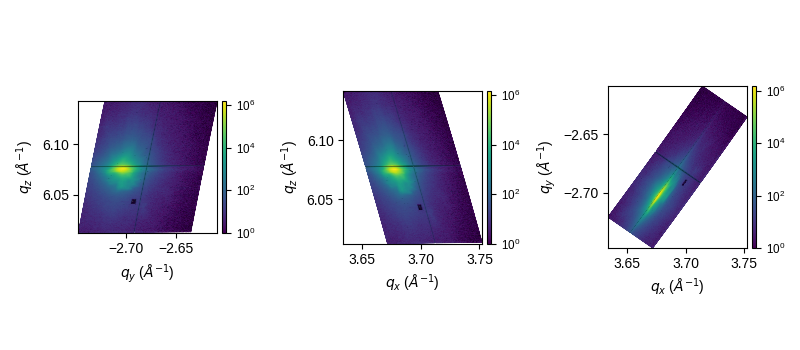

In [28]:
fig, ax = plt.subplots(1,3,figsize=(8,3.5), dpi=100)

ax[0].pcolormesh(qy, qz, fint, norm=LogNorm(), shading='gouraud')
ax[1].pcolormesh(qx, qz, fint, norm=LogNorm(), shading='gouraud')
ax[2].pcolormesh(qx, qy, fint, norm=LogNorm(), shading='gouraud')

[ax[i].set_ylabel(r'$q_z$ ($\AA^{-1}$)') for i in (0,1)]
[ax[i].set_xlabel(r'$q_x$ ($\AA^{-1}$)') for i in (1,2)]

ax[0].set_xlabel(r'$q_y$ ($\AA^{-1}$)')
ax[2].set_ylabel(r'$q_y$ ($\AA^{-1}$)')

for a in ax:
    a.set_aspect('equal')
    sxdm.plot.add_colorbar(a, a.get_children()[0])
    
fig.tight_layout()

A clearer visualisation is perhaps obtained by plotting the `fint` slice in 3D:

Text(0.5, 0, '$q_z~(\\AA^{-1})$')

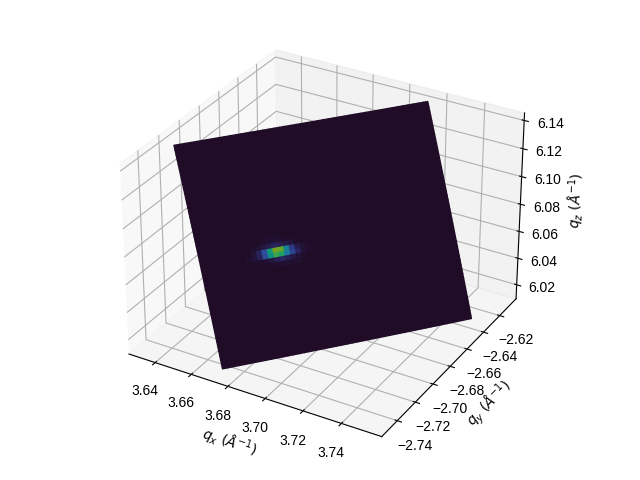

In [29]:
color_map = plt.get_cmap('turbo')
ffint = fint.astype(np.float64)
ffint /= ffint.max()
I = color_map(ffint)

fig = plt.figure(layout='tight')
ax = fig.add_subplot(projection='3d')

ax.plot_surface(qx, qy, qz, facecolors=I)

ax.set_xlabel(r'$q_x~(\AA^{-1})$')
ax.set_ylabel(r'$q_y~(\AA^{-1})$')
ax.set_zlabel(r'$q_z~(\AA^{-1})$')

Once angular offsets have been established, one should proceed to estimate the largest number of bins that can be used to grid the data in q-space. Interpolating intensity on an orthonormal grid is necessary when expressing it in reciprocal space as the data itself, acquired in angular space, is not orthonormal.

In [30]:
sxdm.process.xsocs.estimate_n_bins(path_master_shifted, offsets=offsets)

Subtracting 0 from eta
Subtracting 0 from phi
Subtracting 0 from rhx
Subtracting 0 from rhy
Subtracting 0 from nu
Subtracting 0 from delta


[10, 13, 11]

Based on the output of the above cell and in order to use an isotropic grid size, the number of bins is set to $125^3$ in the function `grid_qspace_xsocs` called below. This function requires an output file as an input, specified below as `qspace_shift_0.h5`, as well as the master XSOCS (shifted) file, `path_master_shifted`.

<div class="alert alert-block alert-danger">
<b>Warning:</b> this will take a while, about 15min on a 40-core machine.
</div>

In [33]:
path_qspace = f'{path_out}/qspace_shift_0.h5'

In [50]:
%%time

try:
    sxdm.process.xsocs.grid_qspace_xsocs(
        path_qspace,
        path_master_shifted,
        (10, 10, 10),
        overwrite=False
    )
except RuntimeError:
    print('> Data exists! Set overwrite=True if needed.\n')

No angular offsets applied!
Process 3 started.Process 7 started.Process 6 started.Process 16 started.Process 13 started.Process 9 started.Process 4 started.Process 8 started.Process 5 started.Process 14 started.Process 21 started.Process 15 started.Process 12 started.Process 26 started.Process 22 started.Process 25 started.Process 27 started.
Process 30 started.Process 0 started.Process 17 started.Process 24 started.Process 28 started.
Process 18 started.Process 23 started.Process 2 started.
Process 31 started.
Process 34 started.Process 29 started.
Process 36 started.Process 10 started.Process 32 started.Process 33 started.
Process 11 started.Process 37 started.Process 1 started.

Process 35 started.




Process 38 started.

Process 39 started.






















Process 20 started.
Process 19 started.
#0/3600
#100/3600
#200/3600
#300/3600
#400/3600
#500/3600
#600/3600
#700/3600
#800/3600
#900/3600
#1000/3600
#1100/3600
#1200/3600
#1300/3600
#1400/3600
#1500/3600
#1600/3600
#1700/3

Once the above cell is run, the file `qspace_shift_0.h5` will contain the sought 5D dataset; namely, $I(x, y, q_x, q_y, q_z)$.

# Determination of a ROI in reciprocal space

First one loads the piezo $(x, y)$ coordinates and the q-space $(q_x, q_y, q_z)$ coordinates from the `master_shifted` and `qspace` files, respectively:

In [34]:
pix, piy = sxdm.io.xsocs.get_piezo_motorpos(path_master_shifted)
qx, qy, qz = sxdm.utils.get_qspace_coords(path_qspace)

Returning pix,piy of shape [60, 60]


Then the *average* q-space intensity is computed by summing over all of the probed $(x, y)$ coordinates using the `get_qspace_avg` function. This takes about 50s on a 40-cores machine - because it makes sense to do this computation only *once* per `qspace` file, the data is saved as an `.npy` array for future use:

In [64]:
# if False:
qspace_avg = sxdm.io.xsocs.get_qspace_avg(path_qspace, n_threads=48)
np.save('qspace_avg.npy', qspace_avg)
    
qspace_avg = np.load('qspace_avg.npy')

  0%|          | 0/48 [00:00<?, ?it/s]

In [65]:
qspace_avg.shape

(10, 10, 10)

The projections along $q_x$, $q_y$ and $q_z$ io this average reciprocal space volume are plotted below.

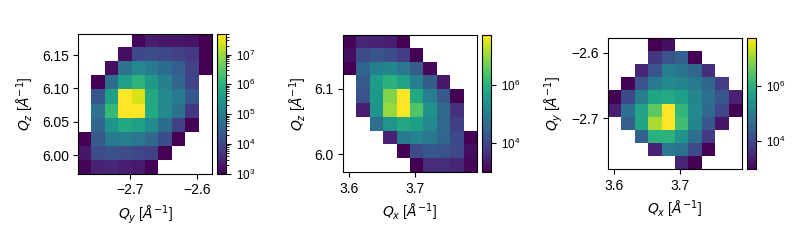

In [36]:
fig, ax = plt.subplots(1, 3, figsize=(8, 2.5), layout='tight')

_qext = sxdm.utils.get_q_extents(qx, qy, qz)
for i in range(3):
    ax[i].imshow(qspace_avg.sum(i).T, extent=_qext[i],
                 origin='lower', aspect='equal', norm=LogNorm(1e3,5e7))
    cbar = sxdm.plot.add_colorbar(ax[i], ax[i].get_images()[0], size='7%')

# labels etc.
ax[0].set_xlabel(r'$Q_y$ [$\AA^{-1}$]')
ax[2].set_ylabel(r'$Q_y$ [$\AA^{-1}$]')

for i in (1, 2):
    ax[i].set_xlabel(r'$Q_x$ [$\AA^{-1}$]')

for i in (0, 1):
    ax[i].set_ylabel(r'$Q_z$ [$\AA^{-1}$]')

The next step is to identify an appropriate sub-volume of interest (VOI) within `qspace_avg`. This VOI corresponds to the region for which centres of mass (COMs) will be computed as a function of $(x, y)$. The widget below is used to determine the indexes of the `qspace_avg` array that slice the array so as to obtain a sought VOI:

IntSlider(value=5, description='depth', max=9)

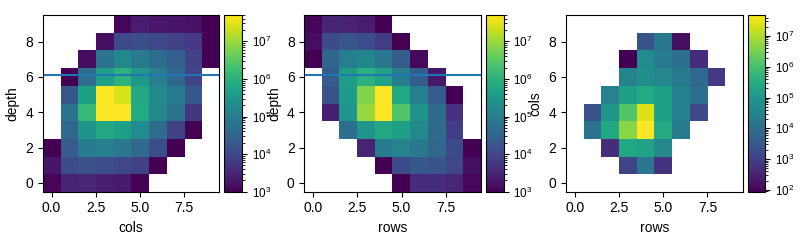

In [37]:
i0 = 5

fig, ax = plt.subplots(1, 3, figsize=(8, 2.5), layout='tight')

im0 = ax[0].imshow(qspace_avg.sum(0).T, norm=LogNorm(1e3,5e7))
lines0 = [ax[i].axhline(qz[i0]) for i in (0, 1)]
ax[0].set_xlabel(r'cols')
ax[0].set_ylabel(r'depth')

im1 = ax[1].imshow(qspace_avg.sum(1).T, norm=LogNorm(1e3,5e7))
ax[1].set_xlabel(r'rows')
ax[1].set_ylabel(r'depth')

imslice = ax[2].imshow(qspace_avg[..., i0].T, norm=LogNorm())
ax[2].set_xlabel(r'rows')
ax[2].set_ylabel(r'cols')

for a in ax:
    cbar = sxdm.plot.add_colorbar(a, a.get_images()[0], size='10%')

fig.subplots_adjust(bottom=.22, top=.9, left=.08, right=.98)
    
def sliceit(change):
    i0 = change['new']
    _0 = [l.set_ydata(i0) for l in lines0]
    imslice.set_data(qspace_avg[..., i0].T)

    ax[2].set_title(f'depth: {i0}')
    fig.canvas.draw()

slider = ipw.IntSlider(value=i0, min=0, max=qspace_avg.shape[-1]-1, description='depth')
slider.observe(sliceit, names='value')
slider

The identified `rows, cols, depth` indexes are used to define a boolean mask that corresponds to the VOI,

In [61]:
mask = np.ones(qspace_avg.shape).astype('bool')
mask[2:6,  2:6, 2:7] = False # rows, cols, depth

as well as other quantities related to it:

In [57]:
roi         = np.where(~mask) # list of VOI indexes
roi_sh      = tuple([x.max()-x.min()+1 for x in roi]) # shape of the VOI
roi_idxs    = [(x.min(), x.max()+1) for x in roi] # VOI in pixel coords
roi_slice   = tuple([slice(x.min(), x.max()+1) for x in roi]) # VOI as slices to preserve shape
roi_qcoords = [q[roi_slice] for q in np.meshgrid(qx, qy, qz, indexing='ij')] # VOI in q-coordinates

qspace_avg_masked = np.ma.masked_array(data=qspace_avg, mask=mask) # VOI via a masked array: original shape
qspace_avg_sliced = qspace_avg[roi_slice] # VOI via slicing: new shape

The VOI can be neatly visualised in 3D using `ipyvolume`. Run the cell below (uncomment it if necessary) and refresh the page to install the javascript files that are necessary to load the module:

In [58]:
# %%bash

# pip install ipyvolume -q # will install in sys-prefix, i.e. the virtual env directory
# pip install ipyvolume --user -q # needed to enable the extension even if not going to use it

# source /data/id01/inhouse/data_analysis/software/pyenvs/sxdm.slurm/bin/activate
# /data/id01/inhouse/data_analysis/software/pyenvs/sxdm.slurm/bin/jupyter \

# nbextension enable --py ipyvolume # will enable it in sys-prefix
# /data/id01/inhouse/data_analysis/software/pyenvs/sxdm.slurm/bin/jupyter \
# nbextension enable --py --user ipyvolume # will enable it in ~/.jupyter/nbconfig/tree.json

In [59]:
import ipyvolume as ipv

roi_surf = []
for i, j, k in ([0,1,2], [0,2,1]):
    for m in (0,1):
        a, b = np.meshgrid(roi_idxs[i], roi_idxs[j])
        c = np.ones((2,2)) * roi_idxs[k][m]
        roi_surf.append(np.array([a,b,c])[[0,j,k]])

fig = ipv.figure()
iso = ipv.plot_isosurface(qspace_avg, level=1e5)

for r in roi_surf:
    ipv.plot_wireframe(*r, color='green')
    
ipv.xlim(0,qspace_avg.shape[0])
ipv.ylim(0,qspace_avg.shape[1])
ipv.zlim(0,qspace_avg.shape[2])

ipv.view(40, 90)
ipv.show()

Alteratively, the VOI is overlaid on the orthogonal projections of `qspace_avg`:

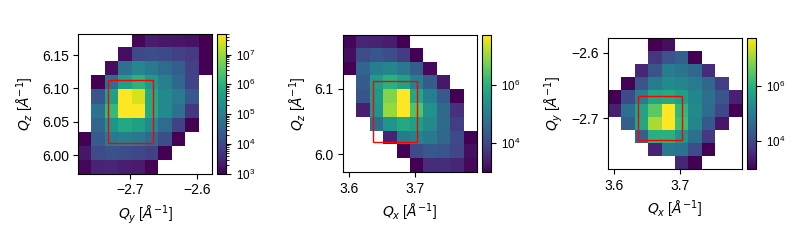

In [60]:
from matplotlib.patches import Rectangle as R

fig, ax = plt.subplots(1, 3, figsize=(8, 2.5), layout='tight')

# draw the _roi as rectangles
_roi = [y for x in roi_qcoords for y in [x.min(), x.max()]]
r2 = R((_roi[0], _roi[2]), _roi[1]-_roi[0], _roi[3]-_roi[2],
       edgecolor='r', facecolor='none', transform=ax[2].transData)  # xy
r1 = R((_roi[0], _roi[4]), _roi[1]-_roi[0], _roi[5]-_roi[4],
       edgecolor='r', facecolor='none', transform=ax[1].transData)  # xz
r0 = R((_roi[2], _roi[4]), _roi[3]-_roi[2], _roi[5]-_roi[4],
       edgecolor='r', facecolor='none', transform=ax[0].transData)  # yz

_qext = sxdm.utils.get_q_extents(qx, qy, qz)
for i, r in zip(range(3), [r0, r1, r2]):
    ax[i].imshow(qspace_avg.sum(i).T, extent=_qext[i],
                 origin='lower', aspect='equal', norm=LogNorm(1e3,5e7))
    ax[i].add_patch(r)
    cbar = sxdm.plot.add_colorbar(ax[i], ax[i].get_images()[0], size='7%')

# labels etc.
ax[0].set_xlabel(r'$Q_y$ [$\AA^{-1}$]')
ax[2].set_ylabel(r'$Q_y$ [$\AA^{-1}$]')

for i in (1, 2):
    ax[i].set_xlabel(r'$Q_x$ [$\AA^{-1}$]')

for i in (0, 1):
    ax[i].set_ylabel(r'$Q_z$ [$\AA^{-1}$]')

# Calculation and visualisation of local structural parameters

if the VOI selection performed in the previous section is satisfactory, one can proceed to compute the COMs of the intensity falling within the VOI as a function of $(x, y)$. This is done with `calc_coms_qspace3d`, which requires as an input the VOI expressed as a tuple of slices (`roi_slice`), and allows one to limit the COM calculation to the N most intense pixels within the VOI via the argument `n_pix=N`. Here only 10 pixels are used:

In [43]:
cx, cy, cz = sxdm.process.math.calc_coms_qspace3d(path_qspace, roi_slice, n_pix=None)

  0%|          | 0/3600 [00:00<?, ?it/s]

Note how for compatibility with XSOCS, COMs are returned as a flat $x*y$ array, i.e.

In [44]:
print(cx.shape)

(3600,)


Next the intensity falling within the VOI is computed:

In [45]:
roi_int = sxdm.process.math.calc_roi_sum(path_qspace, roi_slice)

  0%|          | 0/40 [00:00<?, ?it/s]

The latter is also flattened. The cell below reshapes the `cx, cy, cz, roi_int` arays to $(x, y)$ and masks the portion of each array which have been shifted beforehand:

In [86]:
# (x, y) shift window and extents
pi_win = np.s_[...] 
pi_ext = [pix.min(), pix.max(), piy.min(), piy.max()]

# mask based on (x, y) shift window
dmask = np.ones_like(pix)
dmask[pi_win] = 0

# make masked arrays
cx, cy, cz, roi_int = [np.ma.masked_where(
    dmask != 0, x.reshape(pix.shape)) for x in (cx, cy, cz, roi_int)]

Finally, the values of `cx, cy, cz` are used to compute $\vec{q}(x, y)$. The values of $\vec{q}$ depend on the **origin** with respect to which these are computed. Furthermore, local tilts are only meaningful if defined relative to a reference axis. Thus, $\vec{q}$ is best computed relative to a reference $\vec{q}_\mathsf{ref}$. The choice of $\vec{q}_\mathsf{ref}$ is arbitrary. Here the average COM within the VOI is taken as $\vec{q}_\mathsf{ref}$, in order to visualise the deviations of $\vec{q}(x, y)$ from its *average*:

In [87]:
# origin
# cxm, cym, czm = 0,0,1 
cxm, cym, czm = cx.mean(), cy.mean(), cz.mean()

# local Q vector and its magnitude
Q = np.array([cx, cy, cz])
q = np.sqrt(cx**2 + cy**2 + cz**2)

# average q vector and its magnitude
Q_av = np.array([cxm, cym, czm])
q_av = np.sqrt(cxm**2 + cym**2 + czm**2)

# local and average interplanar distances
d = 2 * np.pi / q
d_av = 2 * np.pi / q_av

# abosulte angle between q and Q : tilt magnitude
_numerator = np.dot(
    Q_av, Q.flatten().reshape(3, Q.shape[1]*Q.shape[2])
)
_denominator = q.flatten() * q_av
tiltmag = np.degrees(np.arccos(_numerator / _denominator))
tiltmag = tiltmag.reshape(q.shape)

# azimuthal angle between q and Q : tilt direction
az = 90 + np.degrees(np.arctan2(cx - cxm, cy - cym))

# compute tilt magnitude + direction in single HSV array
tilt = sxdm.plot.make_hsv(tiltmag, az, stretch=True)

Finally, the computed quantities are plotted (explanation below):

<div class="alert alert-block alert-warning">
    <b>Note:</b> if <code>ipython</code> starts complaining that you have too many figures open, reset the figures with <code>%matplotlib widget</code>.
</div>

Text(0.5, 0, '$q_x$ ($\\AA^{-1}$)')

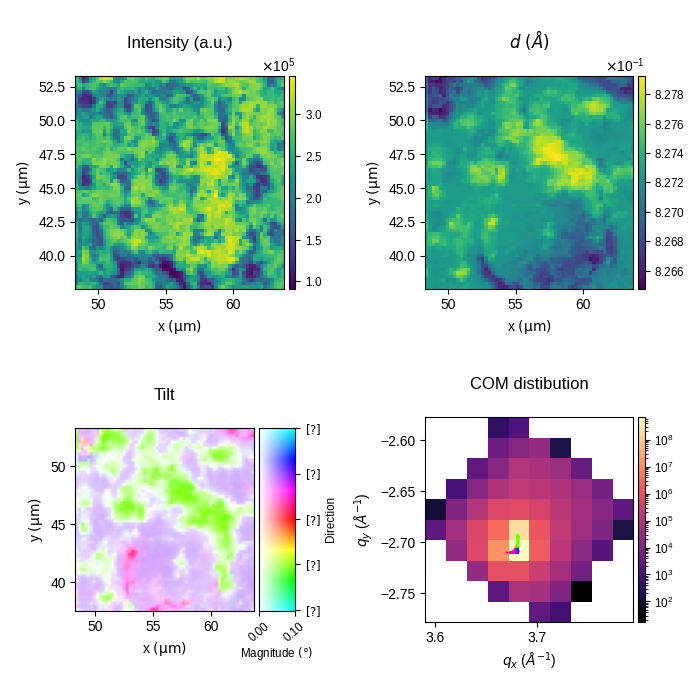

In [88]:
titles = [r"Intensity (a.u.)",rf"$d~(\AA)$",r"Tilt", 'COM distibution']
fig, axs = plt.subplots(
    2,
    2,
    figsize=(7, 7),
#     gridspec_kw=dict(width_ratios=[1, 1.16]),
    layout="tight",
    dpi=100
)
ax = axs.flatten()

# plots
ax[0].imshow(roi_int, extent=pi_ext, cmap="viridis")
ax[1].imshow(d, extent=pi_ext, cmap="viridis")
ax[2].imshow(tilt, extent=pi_ext, cmap="hsv")

_az = np.degrees(np.arctan2(cy-cym, cx-cxm))
qext = [qx.min(), qx.max(), qy.min(), qy.max()]

ax[3].imshow(qspace_avg.sum(2).T, extent=qext, norm=LogNorm(), cmap='magma', origin='lower')
ax[3].scatter(cx, cy, marker='o', s=.5, c=-_az, cmap='hsv', alpha=.5, vmin=-180, vmax=180)

# normal colorbars
for a, t in zip(ax, titles):
    a.set_title(t, pad=20)
    if a != ax[2]:
        cbar = sxdm.plot.add_colorbar(a, a.get_images()[0])
        try:
            cbar.ax.ticklabel_format(scilimits=(0, 0), useMathText=True)
        except:
            pass

# tilt colorbar
labels  = ["$[?]$", "$[?]$", "$[?]$"]
labels += ["$[?]$", "$[?]$"]
sxdm.plot.add_hsv_colorbar(tiltmag, ax[2], labels)

# labels
_ = [a.set_xlabel('x $(\mathsf{\mu m})$') for a in ax[:3]]
_ = [a.set_ylabel('y $(\mathsf{\mu m})$') for a in ax[:3]]

ax[3].set_ylabel(r'$q_y$ ($\AA^{-1}$)')
ax[3].set_xlabel(r'$q_x$ ($\AA^{-1}$)')

The figure above displays, as a function of $(x,y)$ and in clockwise order:

1. The intensity in the VOI;
2. The interplanar distance 
3. The tilt magitude (hue) and direction (color)
4. The distribution of `cx, cy` in the $(q_x, q_y)$ plane, overlaid on the $q_z$ projection of `qspace_avg`.

Note how 3) depends on the specific choice of `cxm, cym, czm`, i.e. of the reference $\vec{q}_\mathsf{ref}$ . These data can be further explored using the widget below. Click around and see the diffraction pattern evolve! The arrow keys can also be used. Have a look at the docstring of `Inspect5DQspace` to see what else it can do.

In [90]:
results = {'interplanar_distance': d, 'roi_intensity': roi_int,
           'tilt': tilt, 'tilt_magnitude': tiltmag, 'tilt_azimuth': az}

viz = sxdm.widgets.xsocs.Inspect5DQspace(
    results,
    path_qspace,
    coms=[cx, cy, cz],
    relim_int=True,
    init_idx=[10, 10],
)

viz.ax[0, 0].get_images()[0].set_cmap("viridis")
viz.fig.set_figwidth(10)
viz.fig.set_figheight(8.5)
viz._iflog.value = True
viz.show()